In [ ]:
!pip install imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
# Load the dataset with the correct delimiter
data = pd.DataFrame(pd.read_csv('/content/water.csv'))  # Default delimiter is comma
print("Dataset loaded successfully!")

# Print the original columns for debugging
print(data.columns)

Dataset loaded successfully!
Index(['Unnamed: 0', 'Customer_ID', 'Day', 'Monthly_Consumption_Trend',
       'Daily_Consumption_Liters', 'Average_Daily_Usage', 'Leakage_Indicator',
       'Seasonal_Consumption_Variation', 'Household_Size',
       'Weekend_vs_Weekday_Consumption', 'Water_Bill_Amount',
       'Consumption_Anomaly_Score', 'Anomaly_Label'],
      dtype='object')


In [ ]:
# Clean column names by removing leading and trailing whitespace
data.columns = data.columns.str.strip()  # Removing leading and trailing spaces
print("Cleaned Columns in dataset:", data.columns)

Cleaned Columns in dataset: Index(['Unnamed: 0', 'Customer_ID', 'Day', 'Monthly_Consumption_Trend',
       'Daily_Consumption_Liters', 'Average_Daily_Usage', 'Leakage_Indicator',
       'Seasonal_Consumption_Variation', 'Household_Size',
       'Weekend_vs_Weekday_Consumption', 'Water_Bill_Amount',
       'Consumption_Anomaly_Score', 'Anomaly_Label'],
      dtype='object')


In [ ]:
# Show the first few rows of the dataset for debugging
data=pd.DataFrame(data)
data.head()

,Unnamed: 0,Customer_ID,Day,Monthly_Consumption_Trend,Daily_Consumption_Liters,Average_Daily_Usage,Leakage_Indicator,Seasonal_Consumption_Variation,Household_Size,Weekend_vs_Weekday_Consumption,Water_Bill_Amount,Consumption_Anomaly_Score,Anomaly_Label
0,0,CUST_0001,1,1.05,1933.105349,1815.160182,0,1.05,7,0,3.866211,0.0,0
1,1,CUST_0001,2,1.05,1875.146702,1815.160182,0,1.05,7,0,3.750293,0.0,0
2,2,CUST_0001,3,1.05,1901.187141,1815.160182,0,1.05,7,0,3.802374,0.0,0
3,3,CUST_0001,4,1.05,1859.476786,1815.160182,0,1.05,7,0,3.718954,0.0,0
4,4,CUST_0001,5,1.05,1965.338143,1815.160182,0,1.05,7,1,3.930676,0.0,0


In [ ]:
#removing first 2 columns i.e. s.n. and customer id
data = data.iloc[:, 2:]
data.head(5)

,Day,Monthly_Consumption_Trend,Daily_Consumption_Liters,Average_Daily_Usage,Leakage_Indicator,Seasonal_Consumption_Variation,Household_Size,Weekend_vs_Weekday_Consumption,Water_Bill_Amount,Consumption_Anomaly_Score,Anomaly_Label
0,1,1.05,1933.105349,1815.160182,0,1.05,7,0,3.866211,0.0,0
1,2,1.05,1875.146702,1815.160182,0,1.05,7,0,3.750293,0.0,0
2,3,1.05,1901.187141,1815.160182,0,1.05,7,0,3.802374,0.0,0
3,4,1.05,1859.476786,1815.160182,0,1.05,7,0,3.718954,0.0,0
4,5,1.05,1965.338143,1815.160182,0,1.05,7,1,3.930676,0.0,0


In [ ]:
# Identify the column that will be used for fraud detection
if 'Daily_Consumption_Liters' not in data.columns:
    raise KeyError("The column 'Daily_Consumption_Liters' does not exist in the dataset.")

# Set fraud detection threshold and create the 'is_fraud' column
fraud_threshold = 1000  # Adjust this threshold based on your analysis
data['is_fraud'] = (data['Daily_Consumption_Liters'] < fraud_threshold).astype(int)
print("Data is ready with 'is_fraud' column created.")

Data is ready with 'is_fraud' column created.


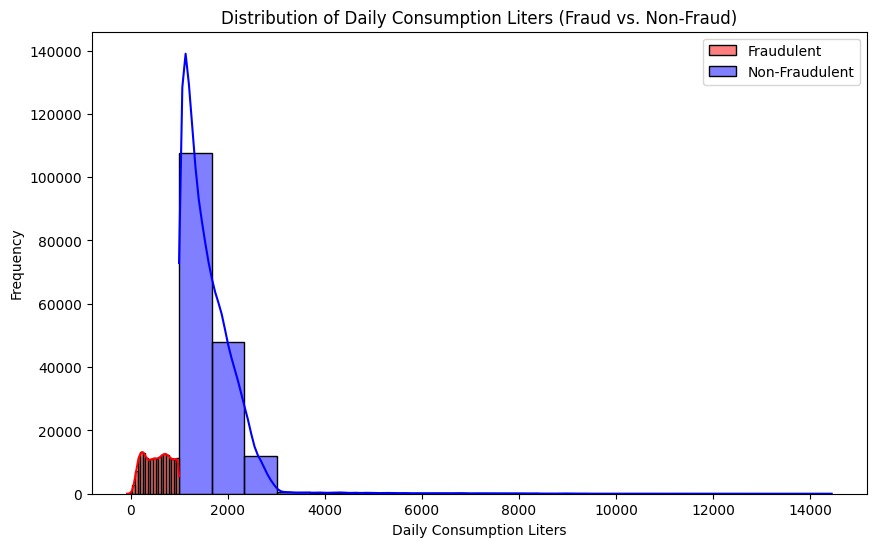

In [ ]:
    fraud_data = data[data['is_fraud'] == 1]
    non_fraud_data = data[data['is_fraud'] == 0]

    # Plotting the distribution of Daily_Consumption_Liters for both fraud and non-fraud cases
    plt.figure(figsize=(10, 6))
    sns.histplot(fraud_data['Daily_Consumption_Liters'], kde=True, color='red', label='Fraudulent', bins=20)
    sns.histplot(non_fraud_data['Daily_Consumption_Liters'], kde=True, color='blue', label='Non-Fraudulent', bins=20)
    plt.title('Distribution of Daily Consumption Liters (Fraud vs. Non-Fraud)')
    plt.xlabel('Daily Consumption Liters')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

<ipython-input-8-7aba53838ca0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_fraud', data=data, palette=['blue', 'red'])


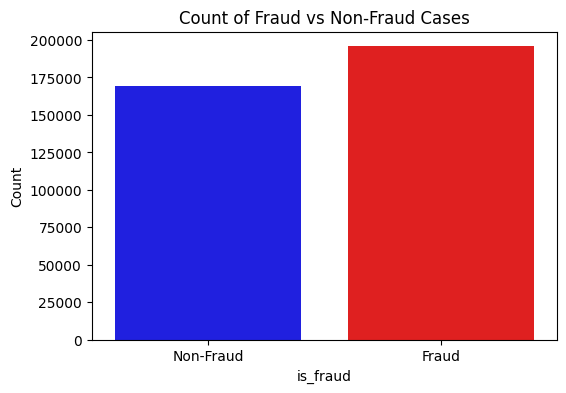

In [ ]:
# Count of fraud vs non-fraud cases
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=data, palette=['blue', 'red'])
plt.title('Count of Fraud vs Non-Fraud Cases')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.ylabel('Count')
plt.show()

In [ ]:
# Features and target
X = data[['Daily_Consumption_Liters']]  # Update feature as necessary
y = data['is_fraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(f"Class distribution after SMOTE: {Counter(y_train)}")

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training set size: (255500, 1), Test set size: (109500, 1)
Class distribution after SMOTE: Counter({0: 137230, 1: 137230})


In [ ]:
# Hyperparameter Tuning for k-NN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5)
grid_knn.fit(X_train, y_train)
knn_classifier = grid_knn.best_estimator_
print("Best Params (k-NN):", grid_knn.best_params_)


Best Params (k-NN): {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


In [ ]:
# Function to test the k-NN model
knn_predictions = knn_classifier.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_predictions)
knn_cr = classification_report(y_test, knn_predictions)

# Calculate separate accuracies
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_fraud_accuracy = accuracy_score(y_test[y_test == 1], knn_predictions[y_test == 1])
knn_non_fraud_accuracy = accuracy_score(y_test[y_test == 0], knn_predictions[y_test == 0])

In [ ]:
print(50 * "-")
print('classification_report : ', knn_cr)
print('knn_accuracy :',  knn_accuracy)
print('fraud_accuracy :', knn_fraud_accuracy)
print('non_fraud_accuracy : ',  knn_non_fraud_accuracy)
print(50 * "-")

--------------------------------------------------
classification_report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     50962
           1       1.00      1.00      1.00     58538

    accuracy                           1.00    109500
   macro avg       1.00      1.00      1.00    109500
weighted avg       1.00      1.00      1.00    109500

knn_accuracy : 1.0
fraud_accuracy : 1.0
non_fraud_accuracy :  1.0
--------------------------------------------------


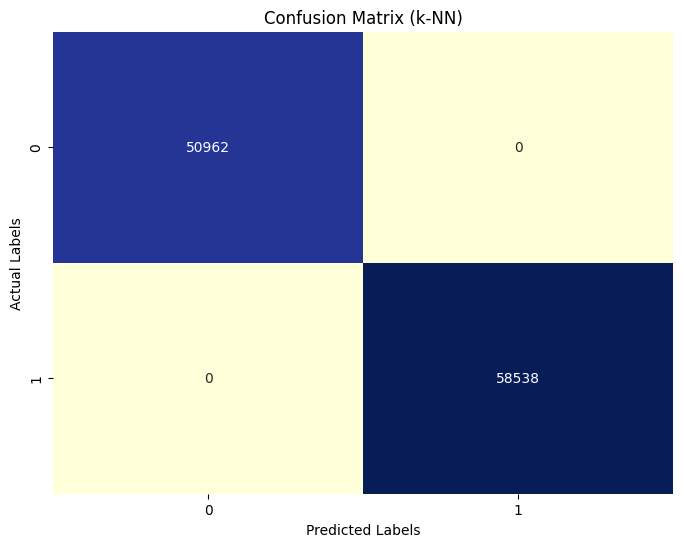

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix (k-NN)")
plt.show()

In [ ]:
# Hyperparameter Tuning for SVM
param_grid_svm = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
}
svm = SVC()
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)
svm_classifier = grid_svm.best_estimator_
print("Best Params (SVM):", grid_svm.best_params_)

In [ ]:
svm_predictions = svm_classifier.predict(X_test)
svm_cm = confusion_matrix(y_test, svm_predictions)
svm_cr = classification_report(y_test, svm_predictions)

# Calculate separate accuracies
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_fraud_accuracy = accuracy_score(y_test[y_test == 1], svm_predictions[y_test == 1])
svm_non_fraud_accuracy = accuracy_score(y_test[y_test == 0], svm_predictions[y_test == 0])

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix (SVM)")
plt.show()

In [ ]:
print(50 * "-")
print('classification_report : ', svm_cr)
print('knn_accuracy :',  svm_accuracy)
print('fraud_accuracy :', svm_fraud_accuracy)
print('non_fraud_accuracy : ',  svm_non_fraud_accuracy)
print(50 * "-")

In [ ]:
# Function to show accuracy comparison of k-NN and SVM
knn_predictions = knn_classifier.predict(X_test)
svm_predictions = svm_classifier.predict(X_test)

knn_accuracy = accuracy_score(y_test, knn_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)

classifiers = ['KNN', 'SVM']
accuracies = [knn_accuracy, svm_accuracy]

# Plotting the accuracies
plt.bar(classifiers, accuracies, color=['blue', 'green'])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN vs. SVM')
plt.ylim(0, 1)
plt.show()